In [42]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization,Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam
from PIL import Image 
import numpy as np
import re
import os 
import glob 
import random
import logging
from tensorflow.keras import backend as K
import math
import cv2
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import matplotlib.pyplot as plt

def visualize(original, augmented, figure_size=(10,5)):
    fig = plt.figure(figsize=figure_size)
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

In [40]:
def isp_it3(img):
    bayer_norm = tf.cast(img, tf.float32) / 255
    black_level = 6 / 255
    white_level = 68 / 255
    bayer_norm = (bayer_norm - black_level)/(white_level - black_level)
    bayer_norm = bayer_norm * white_level
    bayer_norm = np.clip(bayer_norm, 0.0, 1.0)
    #red channel
    bayer_norm[1::2,1::2] = bayer_norm[1::2,1::2]
    #blue channel
    bayer_norm[::2,::2] = bayer_norm[::2,::2] * 1.25
    bayer_norm = bayer_norm * 2.5
    # clip the image to remove false color
    bayer_norm_clipped = np.clip(bayer_norm, 0, 0.18)
    #bayer_norm= np.clip(bayer_norm,0,1)
    bayer = np.array(bayer_norm_clipped * 255, dtype=np.uint8)
    img_rgb = cv2.cvtColor(bayer, cv2.COLOR_BAYER_RG2BGR)  #was BG2RGB  which equates to the same thing but is wrong
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.rotate(img_rgb, cv2.ROTATE_180)
    img_rgb = np.array(255 * (img_rgb/255)**0.45, dtype='uint8')
    return img_rgb

<class 'tensorflow.python.framework.ops.EagerTensor'>
(324, 324, 3)


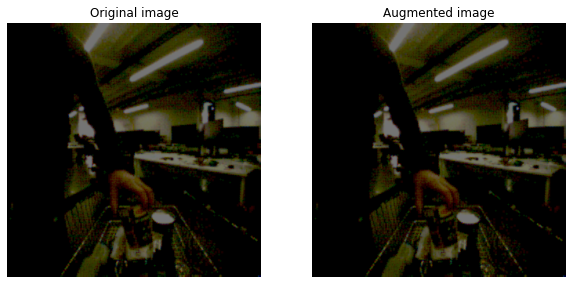

In [41]:
sample_something = "/app/event_detection/data/train/something/1690946037374_3689508_0_3e08da56-2b83-f591-35f5-10e7c21b3d5f.bayer"
sample_2 = "/app/event_detection/data/train/something/1690946224353_3876460_0_86384835-3f94-62cc-9523-e31d807f40fa.bayer"
sample_bayer = tf.io.read_file(sample_2)
sample_bayer = tf.io.decode_raw(sample_bayer, tf.uint8)
image_shape = [324, 324]
sample_bayer = tf.reshape(sample_bayer, image_shape)
sample_bayer = tf.py_function(isp_it3, [sample_bayer], tf.uint8)
visualize(sample_bayer, sample_bayer)

In [57]:
sample_something = "/app/event_detection/data/train/something/1690946037374_3689508_0_3e08da56-2b83-f591-35f5-10e7c21b3d5f.bayer"
sample_2 = "/app/event_detection/data/train/something/1690946224353_3876460_0_86384835-3f94-62cc-9523-e31d807f40fa.bayer"
sample_bayer = tf.io.read_file(sample_2)
sample_bayer = tf.io.decode_raw(sample_bayer, tf.uint8)
image_shape = [324, 324]
sample_bayer = tf.reshape(sample_bayer, image_shape)
sample_bayer = tf.py_function(isp_it3_tf, [sample_bayer], tf.uint8)
visualize(sample_bayer, sample_bayer)

UnknownError: InvalidArgumentError: Incompatible shapes: [324,324] vs. [2,2,2] [Op:Mul]
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/script_ops.py", line 242, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/script_ops.py", line 131, in __call__
    ret = self._func(*args)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-56-92a35b3c9ca6>", line 16, in isp_it3_tf
    bayer_norm = bayer_norm * channel_mask

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py", line 1125, in binary_op_wrapper
    return func(x, y, name=name)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py", line 1457, in _mul_dispatch
    return multiply(x, y, name=name)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py", line 509, in multiply
    return gen_math_ops.mul(x, y, name)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 6166, in mul
    _ops.raise_from_not_ok_status(e, name)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 6843, in raise_from_not_ok_status
    six.raise_from(core._status_to_exception(e.code, message), None)

  File "<string>", line 3, in raise_from

tensorflow.python.framework.errors_impl.InvalidArgumentError: Incompatible shapes: [324,324] vs. [2,2,2] [Op:Mul]

 [Op:EagerPyFunc]

In [46]:
class Demosaic(layers.Layer):
    def __init__(self):
        super(Demosaic, self).__init__()

    def call(self, input_tensor):
        img_rgb = tf.py_function(self.isp_it3, [input_tensor], tf.uint8)
        return img_rgb
    
    def isp_it3(self, img):
        bayer_norm = tf.cast(img, tf.float32) / 255
        black_level = 6 / 255
        white_level = 68 / 255
        bayer_norm = (bayer_norm - black_level)/(white_level - black_level)
        bayer_norm = bayer_norm * white_level
        bayer_norm = np.clip(bayer_norm, 0.0, 1.0)
        #red channel
        bayer_norm[1::2,1::2] = bayer_norm[1::2,1::2]
        #blue channel
        bayer_norm[::2,::2] = bayer_norm[::2,::2] * 1.25
        bayer_norm = bayer_norm * 2.5
        # clip the image to remove false color
        bayer_norm_clipped = np.clip(bayer_norm, 0, 0.18)
        #bayer_norm= np.clip(bayer_norm,0,1)
        bayer = np.array(bayer_norm_clipped * 255, dtype=np.uint8)
        img_rgb = cv2.cvtColor(bayer, cv2.COLOR_BAYER_RG2BGR)  #was BG2RGB  which equates to the same thing but is wrong
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
        img_rgb = cv2.rotate(img_rgb, cv2.ROTATE_180)
        img_rgb = np.array(255 * (img_rgb/255)**0.45, dtype='uint8')
        return img_rgb

In [47]:
demosaic = Demosaic()

In [77]:
def build_net(input_shape=(324,324,1)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    l1 = tf.keras.layers.Conv2D(8, 3, padding="same", use_bias=False)(inputs)
    model = Model(inputs, l1, name="demosaic")
    return model

In [78]:
model = build_net()

In [84]:
def representative_dataset():
    dataset_dir = "/app/event_detection/data/train/something"
    files = glob.glob(dataset_dir + "/*.jpg")
    for file in files:
        img = tf.io.read_file(file)
        img = tf.io.decode_raw(img, tf.uint8)
        img_shape = [324, 324,1]
        img = tf.reshape(img, img_shape)
        img = tf.expand_dims(img, axis=0)
        yield [img]

In [85]:
save_path = "/app/event_detection/models/model.tflite"

In [86]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open(save_path, 'wb') as f:
    f.write(tflite_model)

RuntimeError: Max and min for dynamic tensors should be recorded during calibration: Failed for tensor input_5
Empty min/max for tensor input_5